# Estimação de Receita, Despesa e total de Beneficiarios utilizando Vector Autoregression - Variáveis Exógenas (VARX)

## Resumo
O presente código tem como objetivo realizar a predição da receita, despesa e total de beneficiarios para os próximos três anos relativos a segmentos do mercado de saúde suplementar e para essa estimação foi utilizado algoritmo de VAR para ajustes das curvas de estimação. Para o treinamento da técnica VAR foi aplicado uma combinação de dados, composto pelas variáveis endógenas, adotou se as diferenças entre os dados trimestrais consecutivos. E Após o cálculo de todas as estimações é cálculado o ticket médio e indice sinistralidade referente ao período abordado no estudo.    

### Bibliotecas utilizadas neste código

In [87]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import tight_layout

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [88]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')
    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')
    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')
    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')
    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return

def timeseries_evaluation_metrics_func2(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')
    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')
    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')
    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : {smape(y_true,y_pred)}')
    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    df_evaluation_metrics = pd.DataFrame({'metrics': ['MSE','RMSE','MAE','MAPE','sMAPE','R^2'],
                                          'scores':[mean_squared_error(y_true,y_pred),
                                                    mean_squared_error(y_true,y_pred, squared=False),
                                                    mean_absolute_error(y_true,y_pred),
                                                    mean_absolute_percentage_error(y_true,y_pred),
                                                    smape(y_true,y_pred),
                                                    r2_score(y_true,y_pred)]})

    return df_evaluation_metrics    


def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')

### Carregamento e leitura dos dados

In [89]:
#Definição do segmento a ser estudado neste código
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

#Criação do caminho para a leitura dos arquivo
path = r'D:\TCC\tcc-main\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

#Carregamento na memória da base com dados compilados
ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')

#informações gerais sobre o dataframe
display(ans.info())

display(ans.head(3))

display(ans.tail(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          616 non-null    int64  
 1   cd_ops       616 non-null    int64  
 2   trimestre    616 non-null    object 
 3   receita      616 non-null    float64
 4   despesa      616 non-null    float64
 5   benef        616 non-null    int64  
 6   modalidade   616 non-null    object 
 7   port_ops     616 non-null    object 
 8   contratacao  616 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 43.4+ KB


None

,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
0,2018,303976,2018Q1,29314392.257021,23298026.977992,27209,Cooperativa Médica,Grande,Adesao
1,2018,342084,2018Q1,100884002.779270,71227129.013183,50901,Cooperativa Médica,Grande,Adesao
2,2018,348295,2018Q2,4388045.611102,4255788.456775,6692,Cooperativa Médica,Grande,Adesao


,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
613,2021,335592,2021Q3,41343270.680000,32885588.800000,42301,Cooperativa Médica,Grande,Adesao
614,2021,334561,2021Q3,11510500.130000,10698906.490000,6023,Cooperativa Médica,Grande,Adesao
615,2021,393321,2021Q4,586169428.782351,474987819.997087,282565,Cooperativa Médica,Grande,Adesao


### Agrupamento dos dados de receita, despesa e beneficiários por trimestre

Este dataframe será utilizado nas predições abordadas neste código

In [90]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

#Tratamento de outliers
ans_agrup['despesa'].iloc[3] = (ans_agrup['despesa'].iloc[2] + ans_agrup['despesa'].iloc[4]) / 2.0

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype        
---  ------       --------------  -----        
 0   trimestre    16 non-null     period[Q-DEC]
 1   receita      16 non-null     float64      
 2   despesa      16 non-null     float64      
 3   benef        16 non-null     int32        
 4   n_ops        16 non-null     int32        
 5   pct_despesa  16 non-null     float64      
 6   benefm       16 non-null     float64      
dtypes: float64(4), int32(2), period[Q-DEC](1)
memory usage: 896.0 bytes


,trimestre,receita,despesa,benef,n_ops,pct_despesa,benefm
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,551754.666667
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,555789.666667
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,559564.000000
3,2018Q4,2.380000,1.860000,1693379,38,52.520000,564459.666667
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,566867.333333
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,576833.333333
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,577843.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,585833.666667
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,625470.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,630837.666667


In [91]:
#Criação do campo de diferenças beneficiario médio
ans_agrup['benefm_diff1'] = ans_agrup['benefm'].diff(1)
ans_agrup['benefm_diff2'] = ans_agrup['benefm_diff1'].diff(1)
ans_agrup['benefm_diff3'] = ans_agrup['benefm_diff2'].diff(1)
ans_agrup['benefm_diff4'] = ans_agrup['benefm_diff3'].diff(1)

#Criação do campo de diferenças receita
ans_agrup['receita_diff1'] = ans_agrup['receita'].diff(1)
ans_agrup['receita_diff2'] = ans_agrup['receita_diff1'].diff(1)
ans_agrup['receita_diff3'] = ans_agrup['receita_diff2'].diff(1)
ans_agrup['receita_diff4'] = ans_agrup['receita_diff3'].diff(1)

#Criação do campo de diferenças despesa
ans_agrup['despesa_diff1'] = ans_agrup['despesa'].diff(1)
ans_agrup['despesa_diff2'] = ans_agrup['despesa_diff1'].diff(1)
ans_agrup['despesa_diff3'] = ans_agrup['despesa_diff2'].diff(1)
ans_agrup['despesa_diff4'] = ans_agrup['despesa_diff3'].diff(1)

ans_agrup = ans_agrup[['trimestre',
                       'receita',
                       'receita_diff1',
                       'receita_diff2',
                       'receita_diff3',
                       'receita_diff4',
                       'despesa',
                       'despesa_diff1',
                       'despesa_diff2',
                       'despesa_diff3',
                       'despesa_diff4',
                       'benefm',
                       'benefm_diff1',
                       'benefm_diff2',
                       'benefm_diff3',
                       'benefm_diff4',
                       'n_ops']]

ans_agrup.set_index('trimestre', inplace=True)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   receita        16 non-null     float64
 1   receita_diff1  15 non-null     float64
 2   receita_diff2  14 non-null     float64
 3   receita_diff3  13 non-null     float64
 4   receita_diff4  12 non-null     float64
 5   despesa        16 non-null     float64
 6   despesa_diff1  15 non-null     float64
 7   despesa_diff2  14 non-null     float64
 8   despesa_diff3  13 non-null     float64
 9   despesa_diff4  12 non-null     float64
 10  benefm         16 non-null     float64
 11  benefm_diff1   15 non-null     float64
 12  benefm_diff2   14 non-null     float64
 13  benefm_diff3   13 non-null     float64
 14  benefm_diff4   12 non-null     float64
 15  n_ops          16 non-null     int32  
dtypes: float64(15), int32(1)
memory usage: 2.1 KB


,receita,receita_diff1,receita_diff2,receita_diff3,receita_diff4,despesa,despesa_diff1,despesa_diff2,despesa_diff3,despesa_diff4,benefm,benefm_diff1,benefm_diff2,benefm_diff3,benefm_diff4,n_ops
trimestre,,,,,,,,,,,,,,,,
2018Q1,2.150000,NaN,NaN,NaN,NaN,1.580000,NaN,NaN,NaN,NaN,551754.666667,NaN,NaN,NaN,NaN,38
2018Q2,2.160000,0.010000,NaN,NaN,NaN,1.640000,0.060000,NaN,NaN,NaN,555789.666667,4035.000000,NaN,NaN,NaN,38
2018Q3,2.290000,0.130000,0.120000,NaN,NaN,1.850000,0.210000,0.150000,NaN,NaN,559564.000000,3774.333333,-260.666667,NaN,NaN,38
2018Q4,2.380000,0.090000,-0.040000,-0.160000,NaN,1.860000,0.010000,-0.200000,-0.350000,NaN,564459.666667,4895.666667,1121.333333,1382.000000,NaN,38
2019Q1,2.370000,-0.010000,-0.100000,-0.060000,0.100000,1.870000,0.010000,0.000000,0.200000,0.550000,566867.333333,2407.666667,-2488.000000,-3609.333333,-4991.333333,38
2019Q2,2.460000,0.090000,0.100000,0.200000,0.260000,1.980000,0.110000,0.100000,0.100000,-0.100000,576833.333333,9966.000000,7558.333333,10046.333333,13655.666667,38
2019Q3,2.550000,0.090000,0.000000,-0.100000,-0.300000,1.950000,-0.030000,-0.140000,-0.240000,-0.340000,577843.000000,1009.666667,-8956.333333,-16514.666667,-26561.000000,38
2019Q4,2.650000,0.100000,0.010000,0.010000,0.110000,2.080000,0.130000,0.160000,0.300000,0.540000,585833.666667,7990.666667,6981.000000,15937.333333,32452.000000,38
2020Q1,2.750000,0.100000,0.000000,-0.010000,-0.020000,2.100000,0.020000,-0.110000,-0.270000,-0.570000,625470.000000,39636.333333,31645.666667,24664.666667,8727.333333,39


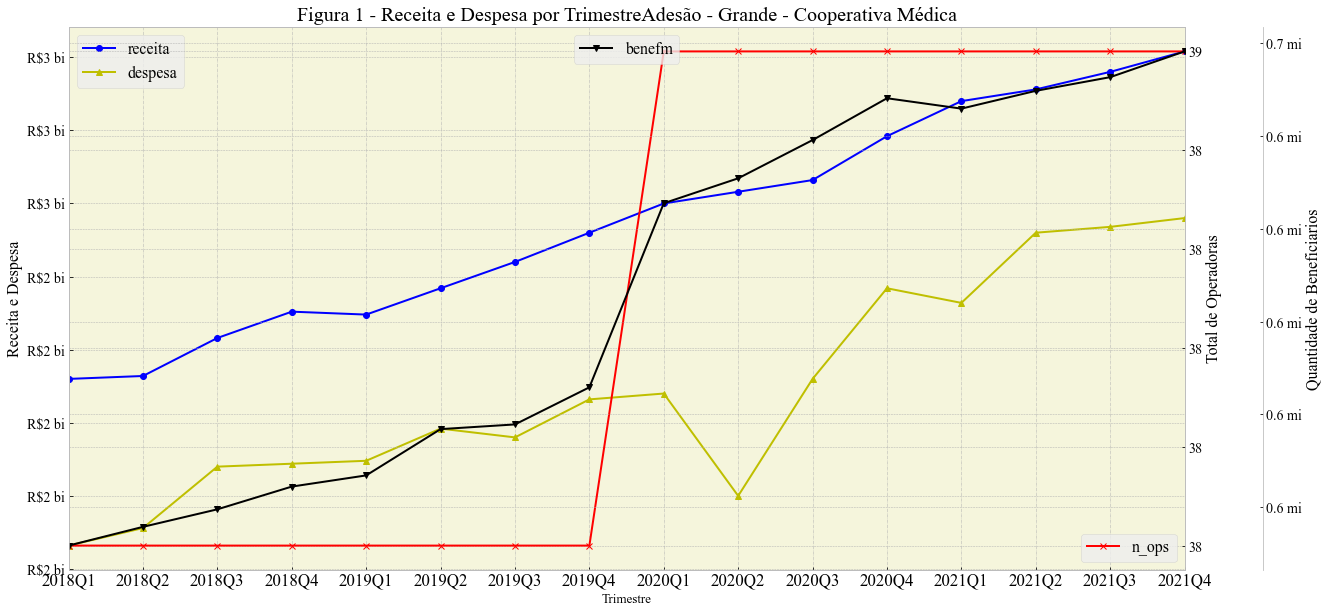

In [92]:
#Visualização geral do dados
df_plot = ans_agrup.copy()

#df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre' + grupo,fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benefm'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [93]:
#Carregamento e leitura do dados das variáveis exógenas
ind_econ_csv = 'ind_econ.csv'

path_ind_con = r'D:\TCC\tcc-main\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + ind_econ_csv

df_exog = pd.read_csv(path_ind_con, sep=';', decimal= ',', encoding='mbcs')

df_exog = df_exog[(df_exog.trimestre > '2017Q4') & (df_exog.trimestre < '2022Q1')]

df_exog = df_exog.reset_index(drop=True)

df_exog['trimestre'] = pd.PeriodIndex(df_exog['trimestre'], freq="Q")

df_exog['PNAD'] = df_exog['PNAD'].astype('float') 

df_exog['Dolar_diff'] = df_exog['Dolar'].diff(1)

df_exog['PNAD_diff'] = df_exog['PNAD'].diff(1) 

df_exog.set_index('trimestre', inplace=True)

df_exog.info()

train_exog = df_exog[2:-2]
test_exog = df_exog[-2:]

print('Dataframe de Treino')
display(train_exog)

print('Dataframe de Teste')
display(test_exog)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPCA        16 non-null     float64
 1   Selic       16 non-null     float64
 2   Dolar       16 non-null     float64
 3   PNAD        16 non-null     float64
 4   Dolar_diff  15 non-null     float64
 5   PNAD_diff   15 non-null     float64
dtypes: float64(6)
memory usage: 896.0 bytes
Dataframe de Treino


,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,
2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000


Dataframe de Teste


,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,
2021Q3,0.030197,0.000123,5.144933,3741.000000,-0.362767,51.000000
2021Q4,0.029580,0.000185,5.376167,3866.000000,0.231234,125.000000


In [94]:
ans_agrup = ans_agrup.merge(df_exog, how='left', on='trimestre')

display(ans_agrup.info())
display(ans_agrup)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   receita        16 non-null     float64
 1   receita_diff1  15 non-null     float64
 2   receita_diff2  14 non-null     float64
 3   receita_diff3  13 non-null     float64
 4   receita_diff4  12 non-null     float64
 5   despesa        16 non-null     float64
 6   despesa_diff1  15 non-null     float64
 7   despesa_diff2  14 non-null     float64
 8   despesa_diff3  13 non-null     float64
 9   despesa_diff4  12 non-null     float64
 10  benefm         16 non-null     float64
 11  benefm_diff1   15 non-null     float64
 12  benefm_diff2   14 non-null     float64
 13  benefm_diff3   13 non-null     float64
 14  benefm_diff4   12 non-null     float64
 15  n_ops          16 non-null     int32  
 16  IPCA           16 non-null     float64
 17  Selic          16 non-null     flo

None

,receita,receita_diff1,receita_diff2,receita_diff3,receita_diff4,despesa,despesa_diff1,despesa_diff2,despesa_diff3,despesa_diff4,benefm,benefm_diff1,benefm_diff2,benefm_diff3,benefm_diff4,n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,,,,,,,,,,,,,,,,,
2018Q1,2.150000,NaN,NaN,NaN,NaN,1.580000,NaN,NaN,NaN,NaN,551754.666667,NaN,NaN,NaN,NaN,38,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
2018Q2,2.160000,0.010000,NaN,NaN,NaN,1.640000,0.060000,NaN,NaN,NaN,555789.666667,4035.000000,NaN,NaN,NaN,38,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2018Q3,2.290000,0.130000,0.120000,NaN,NaN,1.850000,0.210000,0.150000,NaN,NaN,559564.000000,3774.333333,-260.666667,NaN,NaN,38,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
2018Q4,2.380000,0.090000,-0.040000,-0.160000,NaN,1.860000,0.010000,-0.200000,-0.350000,NaN,564459.666667,4895.666667,1121.333333,1382.000000,NaN,38,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
2019Q1,2.370000,-0.010000,-0.100000,-0.060000,0.100000,1.870000,0.010000,0.000000,0.200000,0.550000,566867.333333,2407.666667,-2488.000000,-3609.333333,-4991.333333,38,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,2.460000,0.090000,0.100000,0.200000,0.260000,1.980000,0.110000,0.100000,0.100000,-0.100000,576833.333333,9966.000000,7558.333333,10046.333333,13655.666667,38,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,2.550000,0.090000,0.000000,-0.100000,-0.300000,1.950000,-0.030000,-0.140000,-0.240000,-0.340000,577843.000000,1009.666667,-8956.333333,-16514.666667,-26561.000000,38,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,2.650000,0.100000,0.010000,0.010000,0.110000,2.080000,0.130000,0.160000,0.300000,0.540000,585833.666667,7990.666667,6981.000000,15937.333333,32452.000000,38,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,2.750000,0.100000,0.000000,-0.010000,-0.020000,2.100000,0.020000,-0.110000,-0.270000,-0.570000,625470.000000,39636.333333,31645.666667,24664.666667,8727.333333,39,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000


In [95]:
#Listas com as diferenças das variáveis
columns = ['receita','despesa','benefm']

columns_diff1 = ['receita_diff1','despesa_diff1','benefm_diff1']

columns_diff2 = ['receita_diff2','despesa_diff2','benefm_diff2']

columns_diff3 = ['receita_diff3','despesa_diff3','benefm_diff3']

#Correlação de Pearson entre receita e despesa (Antes da diferenciação)
stats.pearsonr(ans_agrup['receita'],ans_agrup['despesa'])

(0.9281920637615119, 2.1801071055908202e-07)

### Análise gráfica da autocorrelação

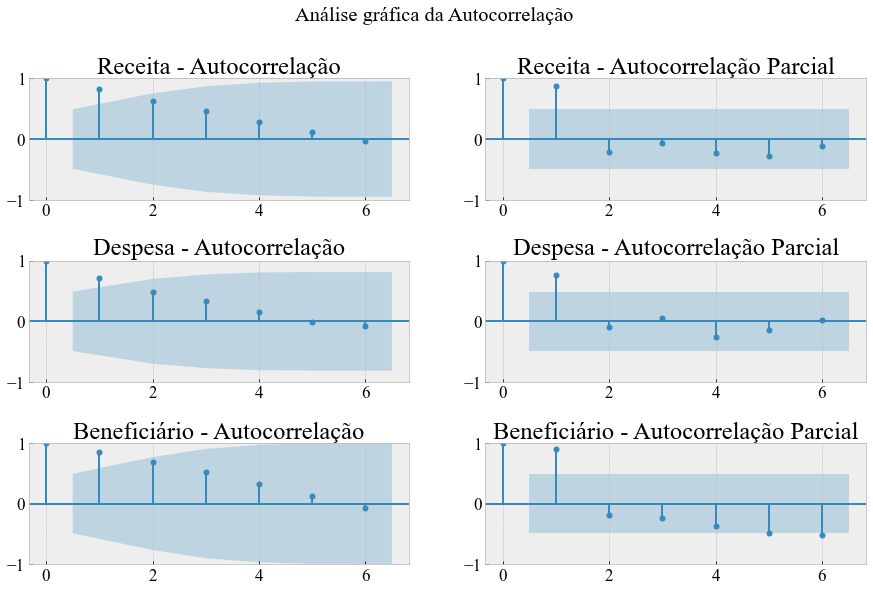

In [96]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

fig.subplots_adjust(top=0.8, hspace=0.5)

fig.suptitle(("Análise gráfica da Autocorrelação"), y=.9)
#Receita
sm.graphics.tsa.plot_acf(ans_agrup['receita'], lags=6, ax=axes[0,0])
axes[0,0].set_title(f'Receita - Autocorrelação')
sm.graphics.tsa.plot_pacf(ans_agrup['receita'], lags=6, ax=axes[0,1])
axes[0,1].set_title(f'Receita - Autocorrelação Parcial')
#Despesa
sm.graphics.tsa.plot_acf(ans_agrup['despesa'], lags=6, ax=axes[1,0])
axes[1,0].set_title(f'Despesa - Autocorrelação')
sm.graphics.tsa.plot_pacf(ans_agrup['despesa'], lags=6, ax=axes[1,1])
axes[1,1].set_title(f'Despesa - Autocorrelação Parcial')
#Benefiário
sm.graphics.tsa.plot_acf(ans_agrup['benefm'], lags=6, ax=axes[2,0])
axes[2,0].set_title(f'Beneficiário - Autocorrelação')
sm.graphics.tsa.plot_pacf(ans_agrup['benefm'], lags=6, ax=axes[2,1])
axes[2,1].set_title(f'Beneficiário - Autocorrelação Parcial')

plt.show()

### Distribuição das variáveis

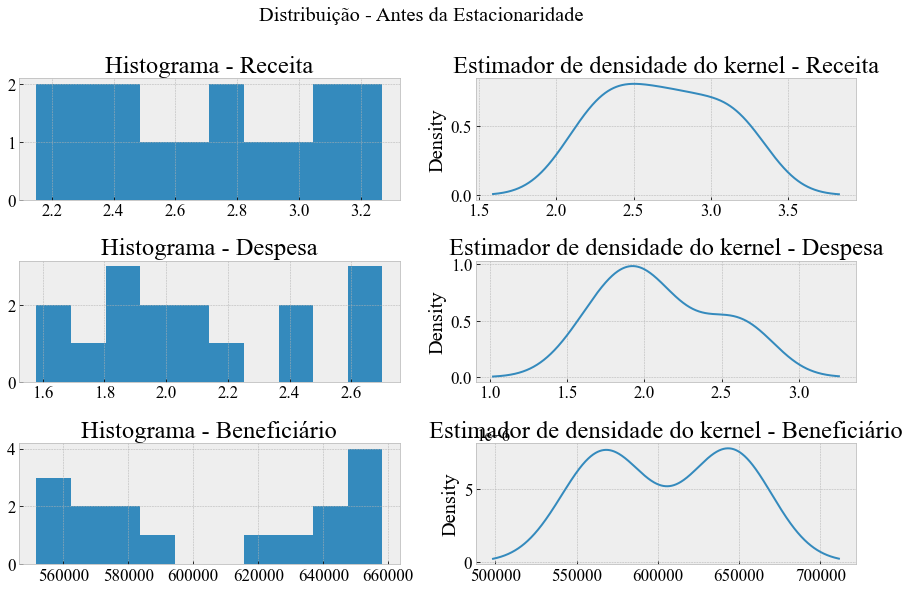

In [97]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

fig.subplots_adjust(top=0.8, hspace=0.5)

fig.suptitle(("Distribuição - Antes da Estacionaridade "), y=.9)
#Receita
ans_agrup['receita'].hist(ax=axes[0,0])
axes[0,0].set_title(f'Histograma - Receita')
ans_agrup['receita'].plot(kind='kde', ax=axes[0,1])
axes[0,1].set_title(f'Estimador de densidade do kernel - Receita')

#Despesa
ans_agrup['despesa'].hist(ax=axes[1,0])
axes[1,0].set_title(f'Histograma - Despesa')
ans_agrup['despesa'].plot(kind='kde', ax=axes[1,1])
axes[1,1].set_title(f'Estimador de densidade do kernel - Despesa')

#Benefiário
ans_agrup['benefm'].hist(ax=axes[2,0])
axes[2,0].set_title(f'Histograma - Beneficiário')
ans_agrup['benefm'].plot(kind='kde', ax=axes[2,1])
axes[2,1].set_title(f'Estimador de densidade do kernel - Beneficiário')

plt.show()

## Preparação dos dados - Estudo da estacionaridade

#### Teste de Estacionaridade (Augmented Dickey Fuller) das variaveis endogenas (Receita, Despesa e Beneficiarios)

In [98]:
for name, column in ans_agrup[columns].iteritems():
    
    Augmented_Dickey_Fuller_Test_func(ans_agrup[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita
Test Statistic                 -0.035131
p-value                         0.955529
No Lags Used                    6.000000
Number of Observartions Used    9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column despesa
Test Statistic                 -0.769615
p-value                         0.827885
No Lags Used                    0.000000
Number of Observartions Used   15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column benefm
Test Statistic                 -0.481419
p-value                         0.895592
No Lags Used  

#### Aplicando as diferenças até encontrar estacionaridade nas variaveis

In [99]:
ans_agrup_test = ans_agrup[columns_diff2].dropna()

for name, column in ans_agrup_test.iteritems():

    Augmented_Dickey_Fuller_Test_func(ans_agrup_test[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita_diff2
Test Statistic                 -4.615790
p-value                         0.000121
No Lags Used                    4.000000
Number of Observartions Used    9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column despesa_diff2
Test Statistic                 -3.295754
p-value                         0.015069
No Lags Used                    3.000000
Number of Observartions Used   10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column benefm_diff2
Test Statistic                 -4.297592
p-value                         0.000448
No Lags Used        

## Especificação do modelo

In [102]:
#Adotou se a segunda diferenças para encontrar ajustar os curvas de estimações de receita, despesa e beneficiarios
columns_test = columns_diff2

X = ans_agrup[columns_test]

train, test = X[0:-2], X[-2:]

train.dropna(inplace = True)

print('Dataframe de Treino')
display(train)

print('Dataframe de Teste')
display(test)

Dataframe de Treino


,receita_diff2,despesa_diff2,benefm_diff2
trimestre,,,
2018Q3,0.120000,0.150000,-260.666667
2018Q4,-0.040000,-0.200000,1121.333333
2019Q1,-0.100000,0.000000,-2488.000000
2019Q2,0.100000,0.100000,7558.333333
2019Q3,0.000000,-0.140000,-8956.333333
2019Q4,0.010000,0.160000,6981.000000
2020Q1,0.000000,-0.110000,31645.666667
2020Q2,-0.060000,-0.370000,-34268.666667
2020Q3,0.000000,0.750000,2866.333333


Dataframe de Teste


,receita_diff2,despesa_diff2,benefm_diff2
trimestre,,,
2021Q3,0.020000,-0.220000,-883.000000
2021Q4,0.010000,0.010000,2598.666667


In [117]:
#Variáveis Exógenas
X_exog = ans_agrup[['IPCA','Selic','Dolar','PNAD','Dolar_diff','PNAD_diff']]

train_exog, test_exog = X_exog[2:-2], X_exog[-2:]
train_exog.dropna(inplace = True)
test_exog.dropna(inplace = True)

print('Dataframe de Treino')
display(train_exog)

print('Dataframe de Teste')
display(test_exog)

Dataframe de Treino


,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,
2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000


Dataframe de Teste


,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,
2021Q3,0.030197,0.000123,5.144933,3741.000000,-0.362767,51.000000
2021Q4,0.029580,0.000185,5.376167,3866.000000,0.231234,125.000000


In [118]:
#Segundo teste de estacionaridade dos dados
for name, column in train[columns_test].iteritems():

    Augmented_Dickey_Fuller_Test_func(train[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita_diff2
Test Statistic                 -3.070663
p-value                         0.028802
No Lags Used                    4.000000
Number of Observartions Used    7.000000
Critical Value (1%)            -4.938690
Critical Value (5%)            -3.477583
Critical Value (10%)           -2.843868
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column despesa_diff2
Test Statistic                 -3.276093
p-value                         0.015982
No Lags Used                    3.000000
Number of Observartions Used    8.000000
Critical Value (1%)            -4.665186
Critical Value (5%)            -3.367187
Critical Value (10%)           -2.802961
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column benefm_diff2
Test Statistic                 -4.978306
p-value                         0.000024
No Lags Used        

### Distribuição - Após a estacionaridade

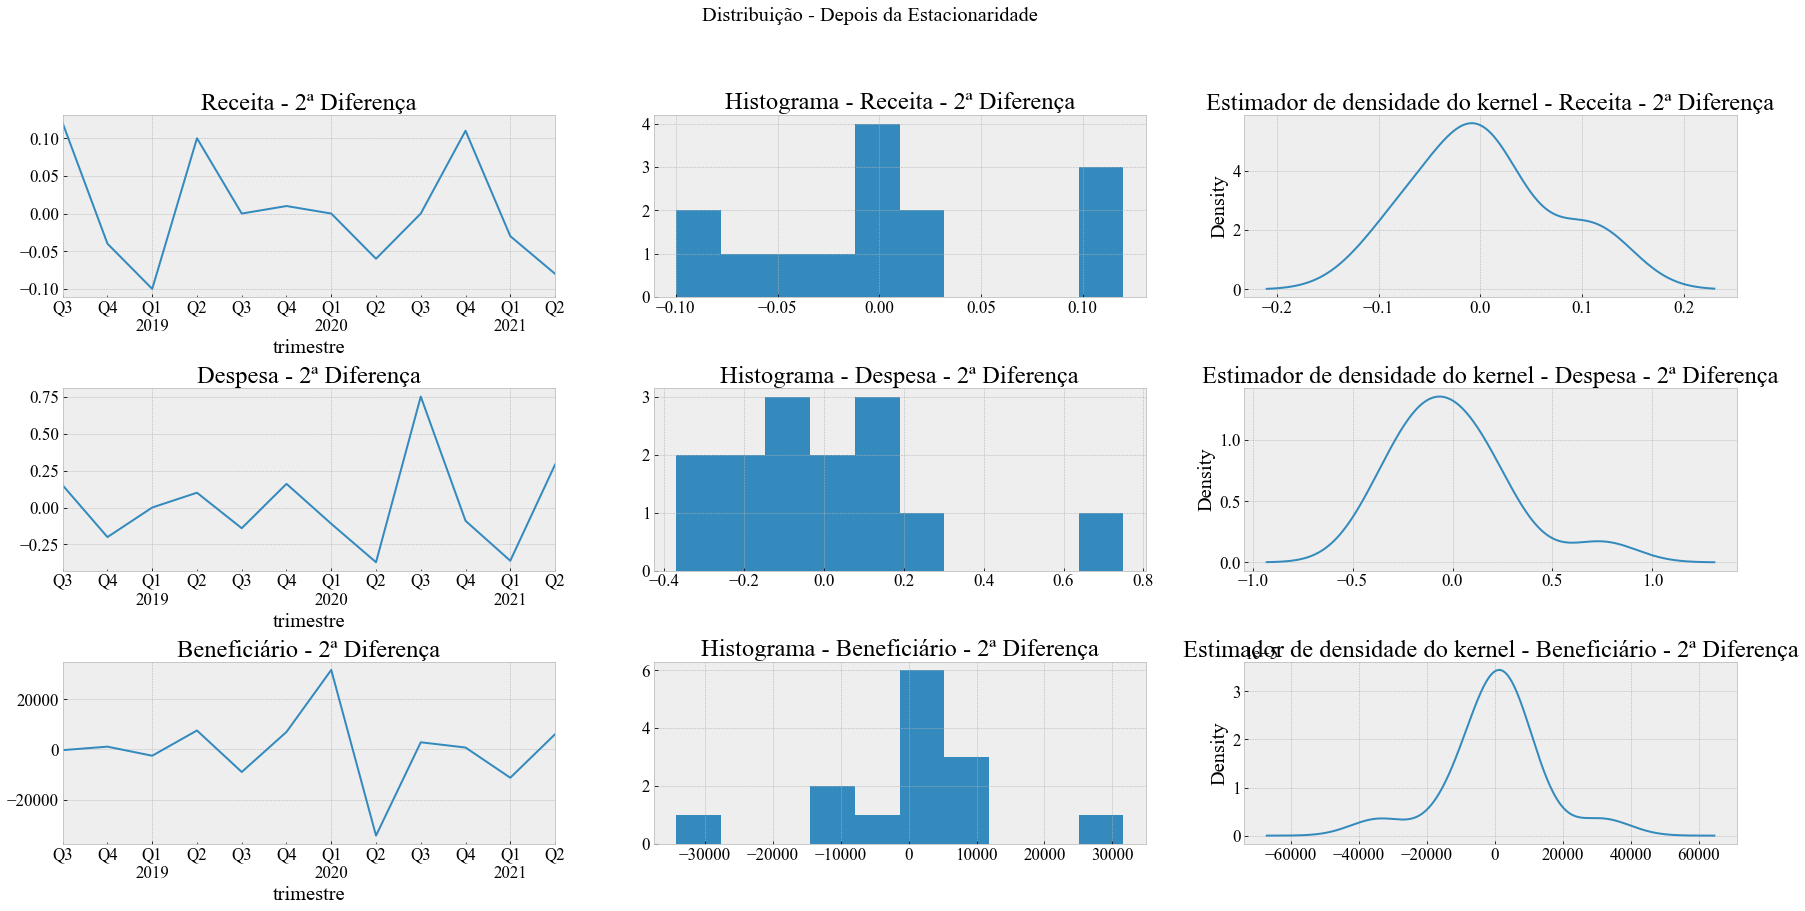

In [119]:
fig, axes = plt.subplots(3, 3, figsize=(30, 15))

fig.subplots_adjust(top=0.8, hspace=0.5)

fig.suptitle(("Distribuição - Depois da Estacionaridade "), y=.9)

#Receita
train['receita_diff2'].plot(ax=axes[0,0])
axes[0,0].set_title(f'Receita - 2ª Diferença')
ans_agrup['receita_diff2'].hist(ax=axes[0,1])
axes[0,1].set_title(f'Histograma - Receita - 2ª Diferença')
ans_agrup['receita_diff2'].plot(kind='kde', ax=axes[0,2])
axes[0,2].set_title(f'Estimador de densidade do kernel - Receita - 2ª Diferença')

#Despesa
train['despesa_diff2'].plot(ax=axes[1,0])
axes[1,0].set_title(f'Despesa - 2ª Diferença')
ans_agrup['despesa_diff2'].hist(ax=axes[1,1])
axes[1,1].set_title(f'Histograma - Despesa - 2ª Diferença')
ans_agrup['despesa_diff2'].plot(kind='kde', ax=axes[1,2])
axes[1,2].set_title(f'Estimador de densidade do kernel - Despesa - 2ª Diferença')

#Benefiário
train['benefm_diff2'].plot(ax=axes[2,0])
axes[2,0].set_title(f'Beneficiário - 2ª Diferença')
ans_agrup['benefm_diff2'].hist(ax=axes[2,1])
axes[2,1].set_title(f'Histograma - Beneficiário - 2ª Diferença')
ans_agrup['benefm_diff2'].plot(kind='kde', ax=axes[2,2])
axes[2,2].set_title(f'Estimador de densidade do kernel - Beneficiário - 2ª Diferença')

plt.show()


### Teste de Cointegração entre as variáveis

In [105]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegratrion_test(df):
    res = coint_johansen(df,-1,4)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]

    def adjust(val, length=6):
        return str(val).ljust(length)
    print('Column Name > Test Stat > C(95%)  =>  Signif \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2),9), '> ', adjust(cvt,8), '=> ', trace > cvt )

cointegratrion_test(train[columns_test])


Column Name > Test Stat > C(95%)  =>  Signif 
 ----------------------------------------
receita_diff2 >  375.08    >  24.2761  =>  True
despesa_diff2 >  236.77    >  12.3212  =>  True
benefm_diff2 >  104.19    >  4.1296   =>  True


### Busca da melhor ordem para ajuste da série

In [106]:
for i in [1,2]:
    model = sm.tsa.VARMAX(train, order=(i,0), exog=train_exog)
    results = model.fit(maxiter=100, disp=False)
    print(f'Order: {i}, AIC: {results.aic}, BIC: {results.bic}')

Order: 1, AIC: 319.1518758172945, BIC: 336.6085152096625
Order: 2, AIC: 769.9639046325993, BIC: 791.7847038730594


In [107]:
#Função para inversão das diferenças
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Teste da ordem definida na etapa anterior

In [120]:
model = sm.tsa.VARMAX(train, order=(1,0), exog=train_exog)
results = model.fit(maxiter=100, disp=False)
display(results.summary())

Dep. Variable:,"['receita_diff2', 'despesa_diff2', 'benefm_diff2']",No. Observations:,12
Model:,VARX(1),Log Likelihood,-123.576
,+ intercept,AIC,319.152
Date:,"Sat, 26 Nov 2022",BIC,336.609
Time:,18:25:17,HQIC,312.689
Sample:,09-30-2018,,
,- 06-30-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.25, 1.83, 1.66",Jarque-Bera (JB):,"0.71, 0.26, 0.99"
Prob(Q):,"0.62, 0.18, 0.20",Prob(JB):,"0.70, 0.88, 0.61"
Heteroskedasticity (H):,"0.34, 1.34, 1.09",Skew:,"0.05, 0.36, 0.18"


## Predição dos valores de testes

In [121]:
fcst = results.forecast(exog=test_exog.values, steps=2)
print('Informações dos dados de estimações teste - Valores Diferenciados')
print('')
display(fcst.info())
display(fcst)
print('')

Informações dos dados de estimações teste - Valores Diferenciados

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2 entries, 2021Q3 to 2021Q4
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   receita_diff2  2 non-null      float64
 1   despesa_diff2  2 non-null      float64
 2   benefm_diff2   2 non-null      float64
dtypes: float64(3)
memory usage: 64.0 bytes


None

,receita_diff2,despesa_diff2,benefm_diff2
2021Q3,-0.180900,0.333787,-12445.129482
2021Q4,-0.509790,0.451313,-42423.672380


### Inversão das diferenciações dos valores estimados

In [122]:
df_pred = pd.DataFrame(fcst, columns=columns_test)
df_pred["new_index"] = range(14,16)
df_pred = df_pred.set_index('new_index')
df_pred.rename({'receita_diff2': 'receita_diff1',
                'despesa_diff2': 'despesa_diff1',
                'benefm_diff2': 'benefm_diff1'}, axis=1, inplace=True)
df_pred

,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
14,-0.180900,0.333787,-12445.129482
15,-0.509790,0.451313,-42423.672380


#### Primeira inversão da diferenciação

In [123]:
#Aplicando a primeira inversão das diferenças
actual_df = ans_agrup[columns_diff1].iloc[:-2]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita_diff1','despesa_diff1','benefm_diff1']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita_diff1,despesa_diff1,benefm_diff1
0,NaN,NaN,NaN
1,0.010000,0.060000,4035.000000
2,0.130000,0.210000,3774.333333
3,0.090000,0.010000,4895.666667
4,-0.010000,0.010000,2407.666667
5,0.090000,0.110000,9966.000000
6,0.090000,-0.030000,1009.666667
7,0.100000,0.130000,7990.666667
8,0.100000,0.020000,39636.333333
9,0.040000,-0.350000,5367.666667


,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
14,-0.180900,0.333787,-12445.129482
15,-0.509790,0.451313,-42423.672380


,receita_diff1,despesa_diff1,benefm_diff1,receita_diff1_1st_inv_diff,despesa_diff1_1st_inv_diff,benefm_diff1_1st_inv_diff
new_index,,,,,,
14,-0.180900,0.333787,-12445.129482,-0.140900,0.573787,-8615.462816
15,-0.509790,0.451313,-42423.672380,-0.650690,1.025100,-51039.135196


#### Segunda inversão da diferenciação

In [124]:
#Aplicando a segunda inversão das diferenças
df_pred = res[[ 'receita_diff1_1st_inv_diff',
                'despesa_diff1_1st_inv_diff',
                'benefm_diff1_1st_inv_diff']]

df_pred.rename({'receita_diff1_1st_inv_diff': 'receita',
                'despesa_diff1_1st_inv_diff': 'despesa',
                'benefm_diff1_1st_inv_diff': 'benefm'}, axis=1, inplace=True)


actual_df = ans_agrup[columns].iloc[:-2]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita','despesa','benefm']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita,despesa,benefm
0,2.150000,1.580000,551754.666667
1,2.160000,1.640000,555789.666667
2,2.290000,1.850000,559564.000000
3,2.380000,1.860000,564459.666667
4,2.370000,1.870000,566867.333333
5,2.460000,1.980000,576833.333333
6,2.550000,1.950000,577843.000000
7,2.650000,2.080000,585833.666667
8,2.750000,2.100000,625470.000000
9,2.790000,1.750000,630837.666667


,receita,despesa,benefm
new_index,,,
14,-0.140900,0.573787,-8615.462816
15,-0.650690,1.025100,-51039.135196


,receita,despesa,benefm,receita_1st_inv_diff,despesa_1st_inv_diff,benefm_1st_inv_diff
new_index,,,,,,
14,-0.140900,0.573787,-8615.462816,2.999100,3.223787,641055.537184
15,-0.650690,1.025100,-51039.135196,2.348410,4.248887,590016.401988


### Métricas de erros dos dados de teste

In [125]:
train = ans_agrup[columns].iloc[:-2]

test = ans_agrup[columns].iloc[-2:]

for i in columns:
    print(f'Evaluation metric for {i}')
    df_evaluation_metrics = timeseries_evaluation_metrics_func2(test[str(i)], res[str(i)+'_1st_inv_diff'])

    df_evaluation_metrics.to_csv('var_errors_metrics_'+ str(i) + '_' + grupo + '.csv',  sep=';', index=False, encoding='mbcs', decimal=',')


Evaluation metric for receita
Mean_Squared_Error_(MSE) is : 0.4448439842295044
Root_Mean_Squared_Error_(RMSE) is : 0.6669662541909481
Mean_Absolute_Error_(MAE) is : 0.5612445733813853
Mean_Absolute_Percentage_Error (MAPE) is : 0.1723063952769041
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : nan
Coefficient of determination R^2 is : -362.1379463098012

Evaluation metric for despesa
Mean_Squared_Error_(MSE) is : 1.352864789023362
Root_Mean_Squared_Error_(RMSE) is : 1.163127159438452
Mean_Absolute_Error_(MAE) is : 1.0513367196927086
Mean_Absolute_Percentage_Error (MAPE) is : 0.39053625247023616
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : nan
Coefficient of determination R^2 is : -6011.732395659287

Evaluation metric for benefm
Mean_Squared_Error_(MSE) is : 2388820829.364799
Root_Mean_Squared_Error_(RMSE) is : 48875.56474727222
Mean_Absolute_Error_(MAE) is : 39854.36374705826
Mean_Absolute_Percentage_Error (MAPE) is : 0.06062857653427483
Symmetrical_Mean_Absolute_Perc

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14 entries, 2018Q1 to 2021Q2
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   receita  14 non-null     float64
 1   despesa  14 non-null     float64
 2   benefm   14 non-null     float64
dtypes: float64(3)
memory usage: 448.0 bytes


In [127]:
test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2 entries, 2021Q3 to 2021Q4
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   receita  2 non-null      float64
 1   despesa  2 non-null      float64
 2   benefm   2 non-null      float64
dtypes: float64(3)
memory usage: 64.0 bytes


In [128]:
df_pred_test = res[['receita_1st_inv_diff','despesa_1st_inv_diff','benefm_1st_inv_diff']]

df_pred_test['trimestre'] = ['2021Q3','2021Q4']

df_pred_test['trimestre'] = pd.PeriodIndex(df_pred_test['trimestre'], freq="Q")

df_pred_test = df_pred_test.rename({'receita_1st_inv_diff': 'receita_pred',
                                    'despesa_1st_inv_diff': 'despesa_pred',
                                    'benefm_1st_inv_diff': 'benefm_pred'}, axis = 1)

df_pred_test.set_index('trimestre', inplace=True)

df_pred_test.info()

df_pred_test

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2 entries, 2021Q3 to 2021Q4
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   receita_pred  2 non-null      float64
 1   despesa_pred  2 non-null      float64
 2   benefm_pred   2 non-null      float64
dtypes: float64(3)
memory usage: 64.0 bytes


,receita_pred,despesa_pred,benefm_pred
trimestre,,,
2021Q3,2.999100,3.223787,641055.537184
2021Q4,2.348410,4.248887,590016.401988


In [129]:
df_pred_test_join = df_pred_test.join(test)

df_pred_test_join = df_pred_test_join[['receita','receita_pred','despesa','despesa_pred','benefm','benefm_pred']]

df_pred_test_join

,receita,receita_pred,despesa,despesa_pred,benefm,benefm_pred
trimestre,,,,,,
2021Q3,3.200000,2.999100,2.670000,3.223787,652617.666667,641055.537184
2021Q4,3.270000,2.348410,2.700000,4.248887,658163.000000,590016.401988


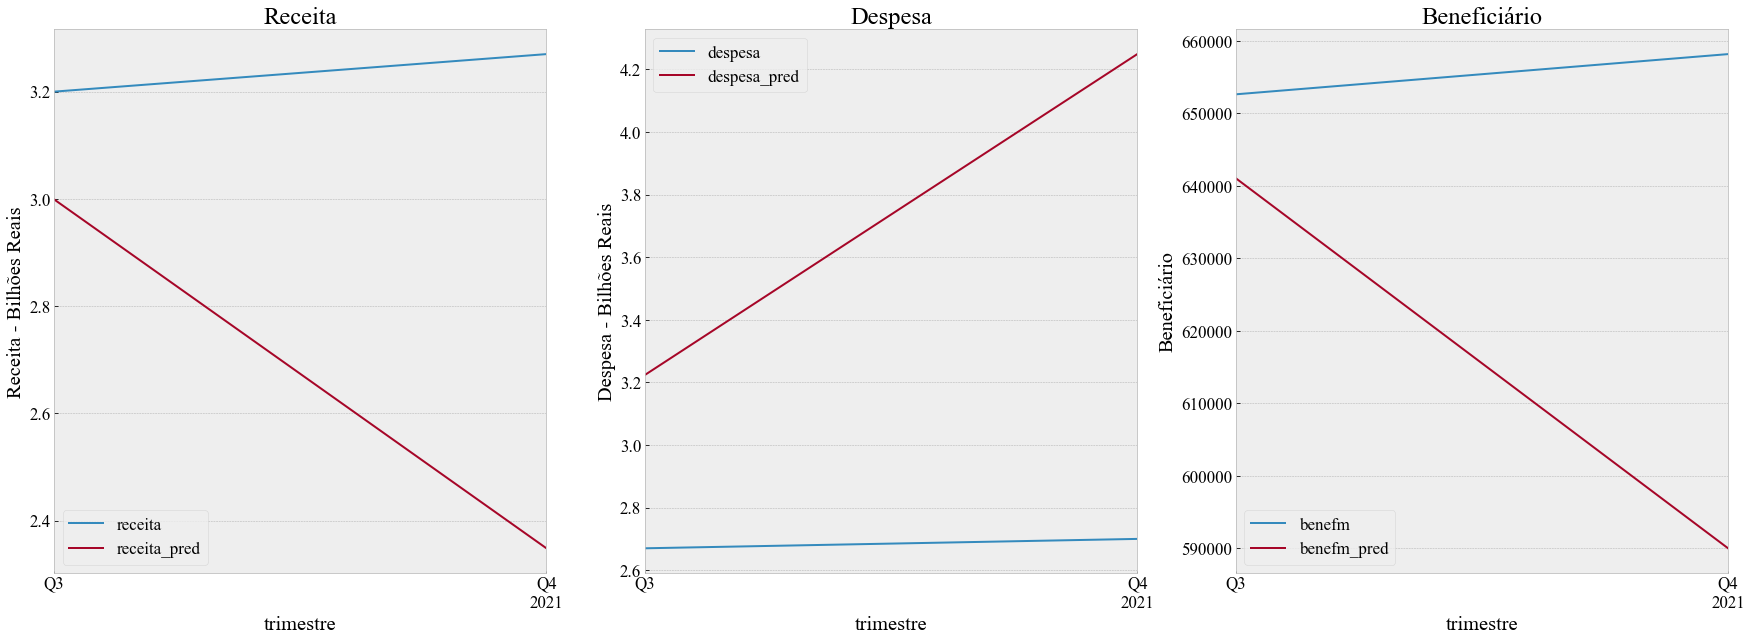

In [130]:
fig, (ax1, ax2, ax3)= plt.subplots(1,3,figsize=(30, 10))

ax1.set_title("Receita")
ax1.set_ylabel('Receita - Bilhões Reais')
df_pred_test_join[['receita','receita_pred']].plot(ax=ax1)

ax2.set_title("Despesa")
ax2.set_ylabel('Despesa - Bilhões Reais')
df_pred_test_join[['despesa','despesa_pred']].plot(ax=ax2)

ax3.set_title("Beneficiário")
ax3.set_ylabel('Beneficiário')
df_pred_test_join[['benefm','benefm_pred']].plot(ax=ax3)

plt.show()

## Estimação da receita, despesa e beneficiários para os próximos anos

In [131]:
columns_test = columns_diff2
X = ans_agrup[columns_test]
X.dropna(inplace = True)

display(X.info())
display(X)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14 entries, 2018Q3 to 2021Q4
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   receita_diff2  14 non-null     float64
 1   despesa_diff2  14 non-null     float64
 2   benefm_diff2   14 non-null     float64
dtypes: float64(3)
memory usage: 448.0 bytes


None

,receita_diff2,despesa_diff2,benefm_diff2
trimestre,,,
2018Q3,0.120000,0.150000,-260.666667
2018Q4,-0.040000,-0.200000,1121.333333
2019Q1,-0.100000,0.000000,-2488.000000
2019Q2,0.100000,0.100000,7558.333333
2019Q3,0.000000,-0.140000,-8956.333333
2019Q4,0.010000,0.160000,6981.000000
2020Q1,0.000000,-0.110000,31645.666667
2020Q2,-0.060000,-0.370000,-34268.666667
2020Q3,0.000000,0.750000,2866.333333


In [136]:
X_exog[2:]

,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,
2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000


In [138]:
#dataframe teste para os 3 próximos anos

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

dolar_list = np.array([5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_list_temp = np.array([X_exog['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list_temp)

pnad_list = [4197, 4312]
pnad_list_temp = [4100]*10
pnad_list.extend(pnad_list_temp)

pnad_diff_list = [0.191, 0.140]
pnad_diff_list_temp = [0.120]*10
pnad_diff_list.extend(pnad_diff_list_temp)

input = {'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar': dolar_list,
         'PNAD' : pnad_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_diff_list}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_pred = pd.DataFrame(input, index = index_df_pred_test)

df_pred

,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
2022Q1,0.032007,0.000242,5.478567,4197,0.102400,0.191000
2022Q2,0.022150,0.000288,4.984900,4312,-0.493667,0.140000
2022Q3,0.030000,0.000200,5.510000,4100,0.525100,0.120000
2022Q4,0.030000,0.000200,5.650000,4100,0.140000,0.120000
2023Q1,0.030000,0.000200,5.545000,4100,-0.105000,0.120000
2023Q2,0.030000,0.000200,5.850000,4100,0.305000,0.120000
2023Q3,0.030000,0.000200,5.900000,4100,0.050000,0.120000
2023Q4,0.030000,0.000200,6.050000,4100,0.150000,0.120000
2024Q1,0.030000,0.000200,6.100000,4100,0.050000,0.120000
2024Q2,0.030000,0.000200,6.150000,4100,0.050000,0.120000


In [139]:
model = sm.tsa.VARMAX(X, order=(1,0), exog=X_exog[2:])
results = model.fit(maxiter=100, disp=False)
display(results.summary())

Dep. Variable:,"['receita_diff2', 'despesa_diff2', 'benefm_diff2']",No. Observations:,14
Model:,VARX(1),Log Likelihood,-133.478
,+ intercept,AIC,338.957
Date:,"Sat, 26 Nov 2022",BIC,361.963
Time:,18:57:09,HQIC,336.827
Sample:,09-30-2018,,
,- 12-31-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.77, 1.93, 0.09",Jarque-Bera (JB):,"0.09, 1.17, 1.12"
Prob(Q):,"0.38, 0.17, 0.76",Prob(JB):,"0.96, 0.56, 0.57"
Heteroskedasticity (H):,"0.28, 2.58, 0.89",Skew:,"-0.16, 0.55, 0.67"


In [140]:
fcst = results.forecast(exog=df_pred.values, steps=12)
print('Informações dos dados de estimações teste - Valores Diferenciados')
print('')
display(fcst.info())
display(fcst)
print('')

Informações dos dados de estimações teste - Valores Diferenciados

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2022Q1 to 2024Q4
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   receita_diff2  12 non-null     float64
 1   despesa_diff2  12 non-null     float64
 2   benefm_diff2   12 non-null     float64
dtypes: float64(3)
memory usage: 384.0 bytes


None

,receita_diff2,despesa_diff2,benefm_diff2
2022Q1,-0.220144,-0.276473,-322.986644
2022Q2,-0.321124,0.035555,27208.888450
2022Q3,0.017921,-0.317095,17358.009407
2022Q4,-0.241753,-0.359371,-7667.676294
2023Q1,-0.193375,0.270445,31143.715277
2023Q2,-0.132753,-0.502344,10640.698425
2023Q3,-0.300655,-0.080944,12434.166473
2023Q4,-0.223498,-0.051968,30696.397499
2024Q1,-0.277776,-0.370457,18070.754333
2024Q2,-0.308229,-0.081734,26907.957396


In [141]:
#Dataframe com os predicts para os próximos anos
df_pred = pd.DataFrame(fcst, columns=columns_test)
df_pred["new_index"] = range(16,28)
df_pred = df_pred.set_index('new_index')
df_pred.rename({'receita_diff2': 'receita_diff1',
                'despesa_diff2': 'despesa_diff1',
                'benefm_diff2': 'benefm_diff1'}, axis=1, inplace=True)
df_pred

,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
16,-0.220144,-0.276473,-322.986644
17,-0.321124,0.035555,27208.888450
18,0.017921,-0.317095,17358.009407
19,-0.241753,-0.359371,-7667.676294
20,-0.193375,0.270445,31143.715277
21,-0.132753,-0.502344,10640.698425
22,-0.300655,-0.080944,12434.166473
23,-0.223498,-0.051968,30696.397499
24,-0.277776,-0.370457,18070.754333


In [142]:
actual_df = ans_agrup[columns_diff1]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita_diff1','despesa_diff1','benefm_diff1']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita_diff1,despesa_diff1,benefm_diff1
0,NaN,NaN,NaN
1,0.010000,0.060000,4035.000000
2,0.130000,0.210000,3774.333333
3,0.090000,0.010000,4895.666667
4,-0.010000,0.010000,2407.666667
5,0.090000,0.110000,9966.000000
6,0.090000,-0.030000,1009.666667
7,0.100000,0.130000,7990.666667
8,0.100000,0.020000,39636.333333
9,0.040000,-0.350000,5367.666667


,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
16,-0.220144,-0.276473,-322.986644
17,-0.321124,0.035555,27208.888450
18,0.017921,-0.317095,17358.009407
19,-0.241753,-0.359371,-7667.676294
20,-0.193375,0.270445,31143.715277
21,-0.132753,-0.502344,10640.698425
22,-0.300655,-0.080944,12434.166473
23,-0.223498,-0.051968,30696.397499
24,-0.277776,-0.370457,18070.754333


,receita_diff1,despesa_diff1,benefm_diff1,receita_diff1_1st_inv_diff,despesa_diff1_1st_inv_diff,benefm_diff1_1st_inv_diff
new_index,,,,,,
16,-0.220144,-0.276473,-322.986644,-0.150144,-0.246473,5222.346689
17,-0.321124,0.035555,27208.888450,-0.471268,-0.210918,32431.235139
18,0.017921,-0.317095,17358.009407,-0.453347,-0.528012,49789.244546
19,-0.241753,-0.359371,-7667.676294,-0.695100,-0.887384,42121.568252
20,-0.193375,0.270445,31143.715277,-0.888475,-0.616938,73265.283529
21,-0.132753,-0.502344,10640.698425,-1.021228,-1.119282,83905.981954
22,-0.300655,-0.080944,12434.166473,-1.321883,-1.200226,96340.148427
23,-0.223498,-0.051968,30696.397499,-1.545381,-1.252194,127036.545926
24,-0.277776,-0.370457,18070.754333,-1.823157,-1.622651,145107.300260


In [143]:
df_pred = res[['receita_diff1_1st_inv_diff','despesa_diff1_1st_inv_diff','benefm_diff1_1st_inv_diff']]

df_pred.rename({'receita_diff1_1st_inv_diff': 'receita',
                'despesa_diff1_1st_inv_diff': 'despesa',
                'benefm_diff1_1st_inv_diff': 'benefm'}, axis=1, inplace=True)

actual_df = ans_agrup[columns]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita','despesa','benefm']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita,despesa,benefm
0,2.150000,1.580000,551754.666667
1,2.160000,1.640000,555789.666667
2,2.290000,1.850000,559564.000000
3,2.380000,1.860000,564459.666667
4,2.370000,1.870000,566867.333333
5,2.460000,1.980000,576833.333333
6,2.550000,1.950000,577843.000000
7,2.650000,2.080000,585833.666667
8,2.750000,2.100000,625470.000000
9,2.790000,1.750000,630837.666667


,receita,despesa,benefm
new_index,,,
16,-0.150144,-0.246473,5222.346689
17,-0.471268,-0.210918,32431.235139
18,-0.453347,-0.528012,49789.244546
19,-0.695100,-0.887384,42121.568252
20,-0.888475,-0.616938,73265.283529
21,-1.021228,-1.119282,83905.981954
22,-1.321883,-1.200226,96340.148427
23,-1.545381,-1.252194,127036.545926
24,-1.823157,-1.622651,145107.300260


,receita,despesa,benefm,receita_1st_inv_diff,despesa_1st_inv_diff,benefm_1st_inv_diff
new_index,,,,,,
16,-0.150144,-0.246473,5222.346689,3.119856,2.453527,663385.346689
17,-0.471268,-0.210918,32431.235139,2.648587,2.242610,695816.581829
18,-0.453347,-0.528012,49789.244546,2.195240,1.714597,745605.826375
19,-0.695100,-0.887384,42121.568252,1.500140,0.827214,787727.394627
20,-0.888475,-0.616938,73265.283529,0.611665,0.210275,860992.678156
21,-1.021228,-1.119282,83905.981954,-0.409564,-0.909007,944898.660110
22,-1.321883,-1.200226,96340.148427,-1.731447,-2.109232,1041238.808537
23,-1.545381,-1.252194,127036.545926,-3.276828,-3.361426,1168275.354463
24,-1.823157,-1.622651,145107.300260,-5.099985,-4.984077,1313382.654723


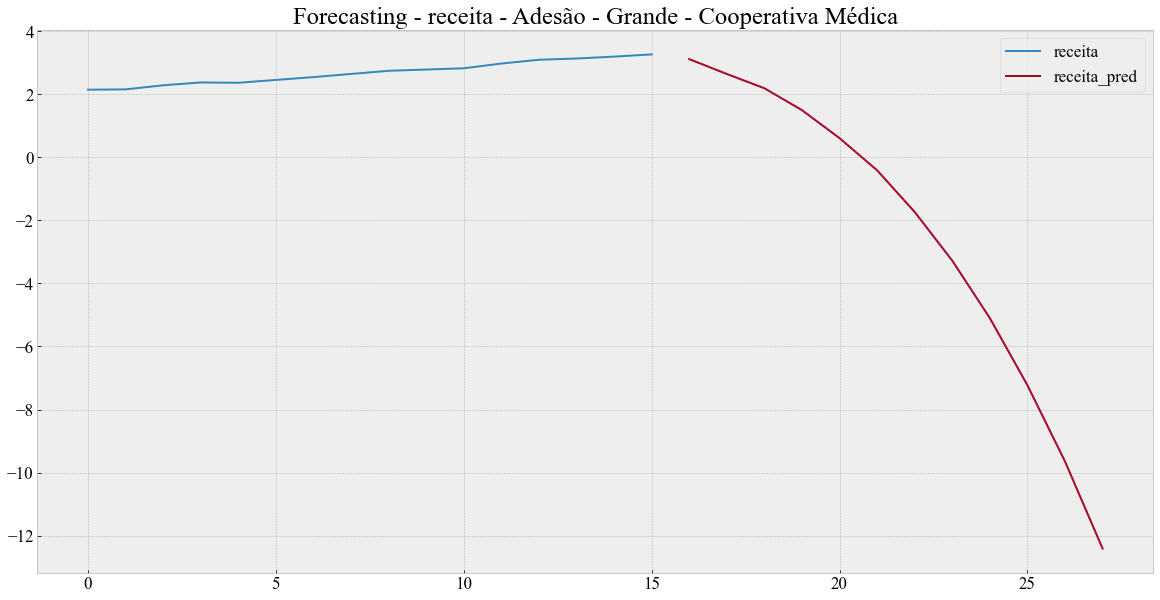

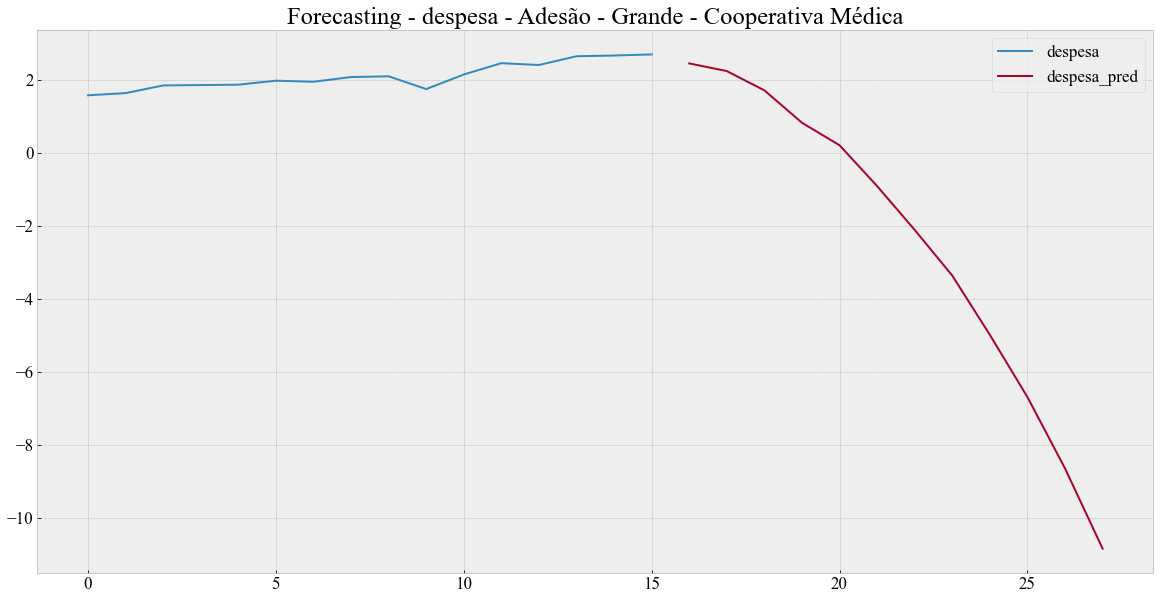

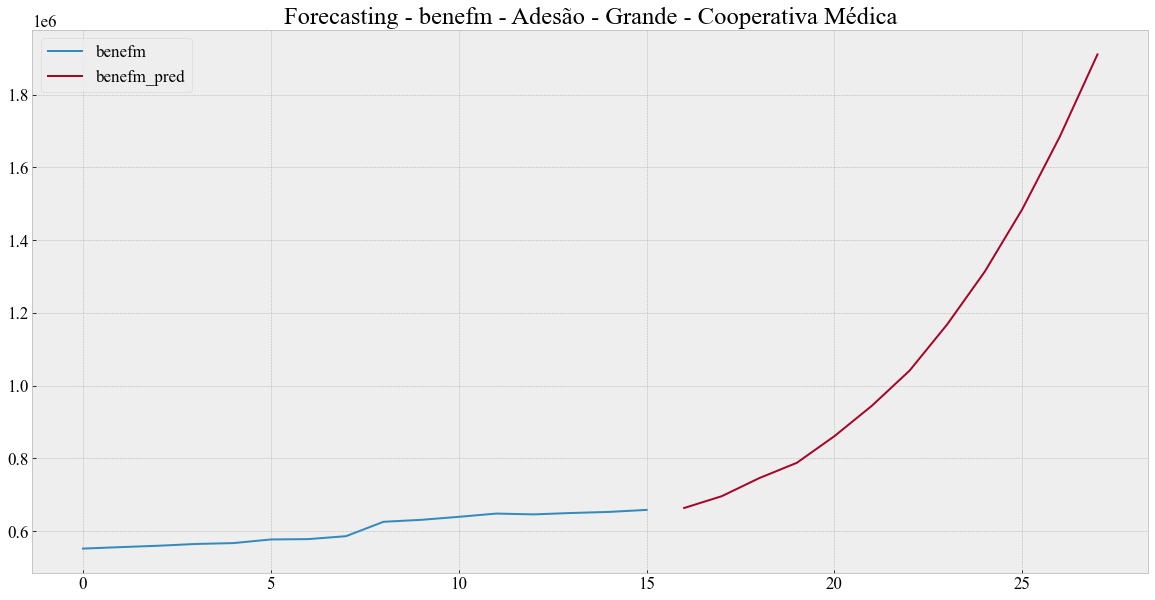

In [144]:
#plotagem das estimações para os próximos tres anos
for i in columns:
    plt.rcParams['figure.figsize'] = [20,10]
    plt.plot(actual_df[i], label= i)
    plt.plot(res[i+'_1st_inv_diff'], label = i+'_pred')
    plt.title(f'Forecasting - ' + i +' - '+ grupo)
    plt.legend(loc='best')
    plt.show()

In [145]:
df = pd.concat([actual_df[['receita','despesa','benefm']], res[['receita_1st_inv_diff', 'despesa_1st_inv_diff', 'benefm_1st_inv_diff']]])

ans_agrup_pred = df.rename({'receita_1st_inv_diff': 'receita_pred', 'despesa_1st_inv_diff': 'despesa_pred', 'benefm_1st_inv_diff': 'benefm_pred'}, axis='columns')

#Cálculo do ticket Médio
ans_agrup_pred['avg_ticket'] = np.where((ans_agrup_pred.index <= 15), ((ans_agrup_pred['receita']*(1e9)/3.0)/ans_agrup_pred['benefm']),
                                                                      ((ans_agrup_pred['receita_pred']*(1e9)/3.0)/ans_agrup_pred['benefm_pred']))


#Cálculo do Indice de Sinistralidade
ans_agrup_pred['ind_sinistralidade'] = np.where((ans_agrup_pred.index <= 15), (ans_agrup_pred['despesa']/ans_agrup_pred['receita'])*100,
                                                                              (ans_agrup_pred['despesa_pred']/ans_agrup_pred['receita_pred'])*100)                                                                      

ans_agrup_pred['trimestre'] = [ '2018Q1','2018Q2','2018Q3','2018Q4',
                                '2019Q1','2019Q2','2019Q3','2019Q4',
                                '2020Q1','2020Q2','2020Q3','2020Q4',
                                '2021Q1','2021Q2','2021Q3','2021Q4',
                                '2022Q1','2022Q2','2022Q3','2022Q4',
                                '2023Q1','2023Q2','2023Q3','2023Q4',
                                '2024Q1','2024Q2','2024Q3','2024Q4']

ans_agrup_pred['trimestre'] = pd.PeriodIndex(ans_agrup_pred['trimestre'], freq="Q")

ans_agrup_pred.to_csv('var_results_'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

ans_agrup_pred = ans_agrup_pred[['trimestre','receita','receita_pred','despesa','despesa_pred','benefm','benefm_pred','avg_ticket','ind_sinistralidade']]

ans_agrup_pred.set_index('trimestre', inplace=True)

ans_agrup_pred.info()

ans_agrup_pred

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28 entries, 2018Q1 to 2024Q4
Freq: Q-DEC
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   receita             16 non-null     float64
 1   receita_pred        12 non-null     float64
 2   despesa             16 non-null     float64
 3   despesa_pred        12 non-null     float64
 4   benefm              16 non-null     float64
 5   benefm_pred         12 non-null     float64
 6   avg_ticket          28 non-null     float64
 7   ind_sinistralidade  28 non-null     float64
dtypes: float64(8)
memory usage: 2.0 KB


,receita,receita_pred,despesa,despesa_pred,benefm,benefm_pred,avg_ticket,ind_sinistralidade
trimestre,,,,,,,,
2018Q1,2.150000,NaN,1.580000,NaN,551754.666667,NaN,1298.886462,73.488372
2018Q2,2.160000,NaN,1.640000,NaN,555789.666667,NaN,1295.454096,75.925926
2018Q3,2.290000,NaN,1.850000,NaN,559564.000000,NaN,1364.157332,80.786026
2018Q4,2.380000,NaN,1.860000,NaN,564459.666667,NaN,1405.473907,78.151261
2019Q1,2.370000,NaN,1.870000,NaN,566867.333333,NaN,1393.624140,78.902954
2019Q2,2.460000,NaN,1.980000,NaN,576833.333333,NaN,1421.554464,80.487805
2019Q3,2.550000,NaN,1.950000,NaN,577843.000000,NaN,1470.987794,76.470588
2019Q4,2.650000,NaN,2.080000,NaN,585833.666667,NaN,1507.822755,78.490566
2020Q1,2.750000,NaN,2.100000,NaN,625470.000000,NaN,1465.564562,76.363636


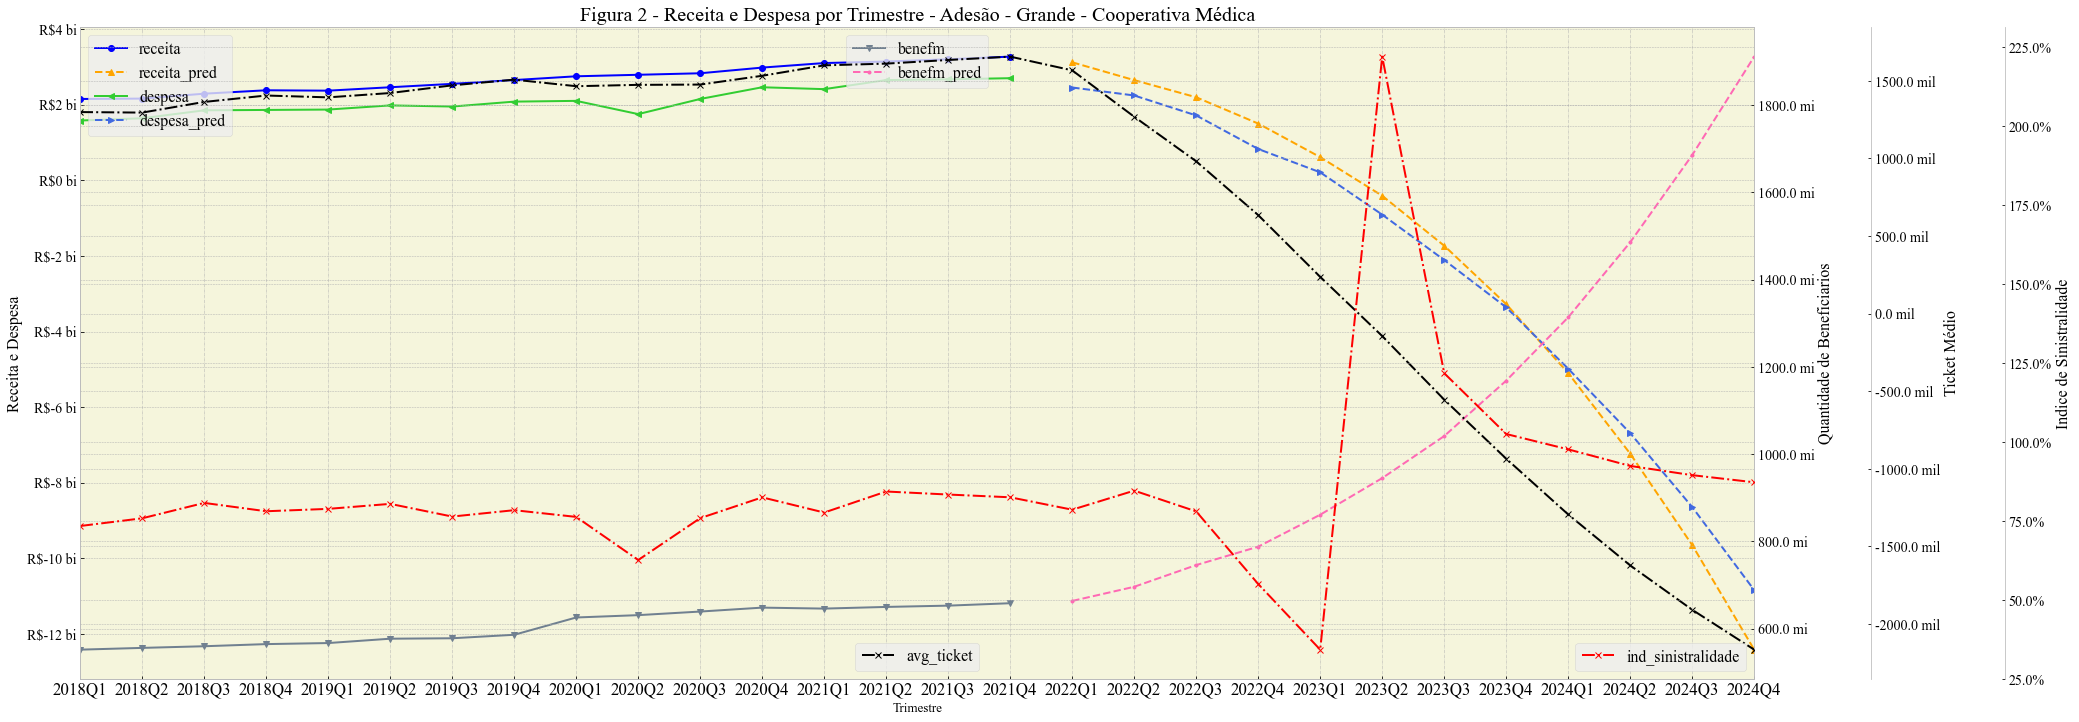

In [146]:
df_plot = ans_agrup_pred

#df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','receita_pred','despesa','despesa_pred'],figsize=(30, 12), color=['blue','orange','limegreen','royalblue'], style=['o-','^--','<-','>--'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - ' + grupo, fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['benefm', 'benefm_pred'], color=['slategray','hotpink'],style=['v-','.--'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(['{:.1f} mi'.format(x/1e3) for x in yticks], fontsize = 14)
ax2.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['avg_ticket'], style=['kx-.'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Ticket Médio', fontsize=16)
ax3.legend(loc = 'lower center', fontsize = 16)

ax4 = ax1.twinx()

ax4.spines.right.set_position(("axes", 1.15))

df_plot.plot(y=['ind_sinistralidade'], color=['red'], style=['x-.'], ax=ax4)
ax4.set_xticks(df_plot.index)
ax4.set_xticklabels(df_plot.index)
ax4.set_xlabel('Trimestre', fontsize = 13)
yticks = ax4.get_yticks()
ax4.set_yticklabels(['{:.1f}%'.format(x) for x in yticks], fontsize = 14)
ax4.set_ylabel('Indice de Sinistralidade', fontsize=16)
ax4.legend(loc = 'lower right', fontsize = 16)

plt.savefig(grupo + '_var_pred.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot